In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte

# Don't forget to make F_L, F_R lists
# Make everything work with eps list
# Comment and delete old methods
# Make sure all imports are relevant


In [2]:

def main():
    # Initialize the simulation parameters
    N = 1
    
    gamma_L= 0.5
    gamma_R = 0

    eps = 1
    mu_L= 1
    mu_R= 1

    T_L = 1  
    T_R= 1

    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1

    eps_list = []

    for i in range(N):
        eps_list.append(1)

  
    time = 1
    dt = 0.001
    nt = int(time/dt)

 
    # Build hamiltonians
    exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

    print("Exact Ham ", exact_diag_ham)
    ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R,J)
   
    print("Ham real: ", ham_real)
    print("Ham imag: ", ham_imag)
    # Build initial states
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
    print("Initil State : " , vqte_init_state)
    print("Exact Initial : ", exact_diag_init_state)

    # Calculate Exact Diag Results
    #exact_diag_results = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)

    # Calculate VQTE Results
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
    
    exact_diag_results = []


    # Output results
    output_results(vqte_results, exact_diag_results, time, nt)
    print(vqte_results[0][-1])
 
    
    

Exact Ham  [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Ham real:  SparsePauliOp(['IZ', 'ZI', 'XY', 'YX', 'XY', 'YX'],
              coeffs=[-0.5+0.j,  0.5+0.j, -0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j])
Ham imag:  SparsePauliOp(['XX', 'YY', 'XX', 'YY', 'II', 'ZI', 'IZ'],
              coeffs=[-0.125+0.j,  0.125+0.j,  0.   +0.j,  0.   +0.j,  0.25 +0.j, -0.   +0.j,
 -0.   +0.j])
Initil State :  Statevector([ 1.0000000e+00+7.34788079e-16j,
             -2.4492936e-16-2.99951957e-32j,
             -3.6739404e-16-8.99855870e-32j,
             -1.2246468e-16-5.47382213e-48j],
            dims=(2, 2))
Exact Initial :  []
This should say 1:  1
[[]]
Initial expectation values:
[np.float64(0.0)]
Step 1 out of 1000
Step 2 out of 1000
Step 3 out of 1000
Step 4 out of 1000
Step 5 out of 1000
Step 6 out of 1000
Step 7 out of 1000
Step 8 out of 1000
Step 9 out of 1000
Step 10 out of 1000
Step 11 out of 1000
Step 12 out of 1000
Step 13 out of 1000
Step 14 out of 1000
Step 15 out of 1000
Step 16 out of 1000
Step 

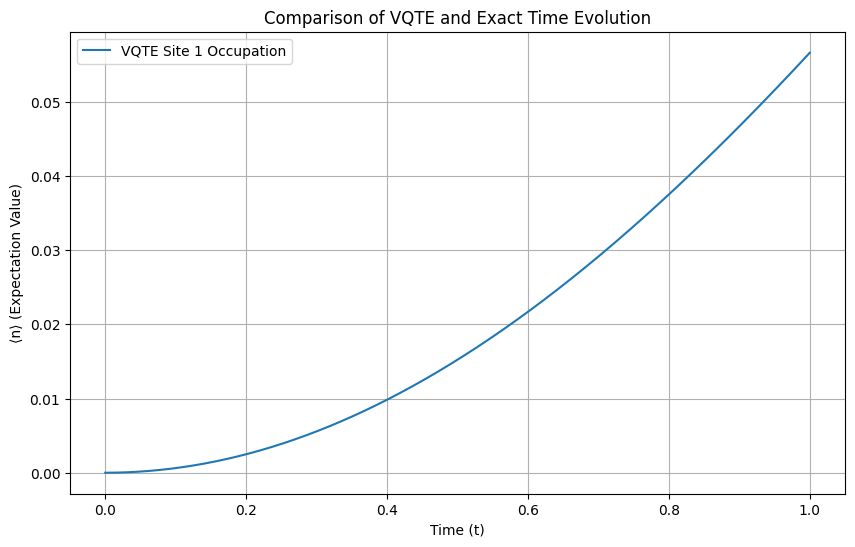

0.05659671010805001


In [3]:
main()